In [5]:
include("cosmology_vars.jl")
include("nu_osc_params.jl")

using DelimitedFiles
using Plots
using Interpolations
using LaTeXStrings
using QuadGK
using SpecialFunctions;

In [6]:
function F0_tint_func(F0vec::Vector{Float64})
    es = range(0, 100, 2000)
    F0int_ne = Interpolations.interpolate((vec(es),), F0vec, Gridded(Linear()))
    return extrapolate(F0int_ne, 0.0)
end

F0s_vec = readdlm("F0s_vec.txt", comments=true)

F0_νe_270sm, F0_νebar_270sm, F0_νx_270sm = F0_tint_func(vec(F0s_vec[:, 1])), F0_tint_func(vec(F0s_vec[:, 2])), F0_tint_func(vec(F0s_vec[:, 3]))
F0_νe_112sm, F0_νebar_112sm, F0_νx_112sm = F0_tint_func(vec(F0s_vec[:, 4])), F0_tint_func(vec(F0s_vec[:, 5])), F0_tint_func(vec(F0s_vec[:, 6]))
F0_νe_bh, F0_νebar_bh, F0_νx_bh = F0_tint_func(vec(F0s_vec[:, 7])), F0_tint_func(vec(F0s_vec[:, 8])), F0_tint_func(vec(F0s_vec[:, 9]))

function F0(E, β, sm)
    if β == "e" && sm == "small"
        return F0_νe_112sm(E)
    elseif β == "e" && sm == "large"
        return F0_νe_270sm(E)
    elseif β == "e" && sm == "bh"
        return F0_νe_bh(E)
    elseif β == "ebar" && sm == "small"
        return F0_νebar_112sm(E)
    elseif β == "ebar" && sm == "large"
        return F0_νebar_270sm(E)
    elseif β == "ebar" && sm == "bh"
        return F0_νebar_bh(E)   
    elseif β == "x" && sm == "small"
        return F0_νx_112sm(E)
    elseif β == "x" && sm == "large"
        return F0_νx_270sm(E)
    elseif β == "x" && sm == "bh"
        return F0_νx_bh(E)
    else
        return 0
    end
end;

In [7]:
# Oscillations thru the SN medium
# Accounting for oscillations thru the SN medium

s12 = 0.297
c12 = 1 - s12
PH = 0

# ordering = "NO" (normal ordering) or "IO" (inverted ordering)
function F(E, β, sm, ordering)
    if ordering == "NO"
        if β == "e"
            return F0(E, "x", sm)
        elseif β == "ebar"
            return c12*F0(E, "ebar", sm) + s12*F0(E, "x", sm)
        elseif β == "x"
            return 0.5*(F0(E, "e", sm) + F0(E, "x", sm))
        elseif β == "xbar"
            return 0.5*(s12*F0(E, "ebar", sm) + (1 + c12)*F0(E, "x", sm))
        else
            return 0
        end
    elseif ordering == "IO"
        if β == "e"
            return s12*F0(E, "e", sm) + c12*F0(E, "x", sm)
        elseif β == "ebar"
            return F0(E, "x", sm)
        elseif β == "x"
            return 0.5*(c12*F0(E, "e", sm) + (1 + s12)*F0(E, "x", sm))
        elseif β == "xbar"
            return 0.5*(F0(E, "ebar", sm) + F0(E, "x", sm))
        else
            return 0
        end
    else
        return 0
    end
end

# In the mass basis now: i = 1, 2, 3, nubar = true or false
function Fmass(E, i, sm, ordering, nubar)
    if nubar==false
        return Usqred(ordering)[1, i]*F(E, "e", sm, ordering) + (1 - Usqred(ordering)[1, i])*F(E, "x", sm, ordering)
    elseif nubar==true
        return Usqred(ordering)[1, i]*F(E, "ebar", sm, ordering) + (1 - Usqred(ordering)[1, i])*F(E, "x", sm, ordering)
    else
        return 0
    end
end;

In [8]:
# In the mass basis, which is what we want for propagation thru the vacuum
function DSNB_integrand(E, z, i, ordering, nubar, bh_frac)
    c0 = 3e8 # m s^(-1)
    if bh_frac == "21"
        return (c0*SNRnorm*SFR(z)/Hubble(z)) * (ηAD(15, 8)*Fmass(E*(1+z), i, "small", ordering, nubar) 
        + (ηAD(22, 15)+ηAD(27, 25))*Fmass(E*(1+z), i, "large", ordering, nubar) + (ηAD(25, 22)+ηAD(125, 27))*Fmass(E*(1+z), i, "bh", ordering, nubar))
    elseif bh_frac == "41"
        return (c0*SNRnorm*SFR(z)/Hubble(z)) * (ηAD(15, 8)*Fmass(E*(1+z), i, "small", ordering, nubar) 
        + ηAD(125, 15)*Fmass(E*(1+z), i, "bh", ordering, nubar))
    elseif bh_frac == "09"
        return (c0*SNRnorm*SFR(z)/Hubble(z)) * (ηAD(15, 8)*Fmass(E*(1+z), i, "small", ordering, nubar)
        + ηAD(40, 15)*Fmass(E*(1+z), i, "large", ordering, nubar) + ηAD(125, 40)*Fmass(E*(1+z), i, "bh", ordering, nubar))
    else
        return 0
    end
end

function DSNB_integrand_ccsn(E, z, i, ordering, nubar, bh_frac)
    c0 = 3e8 # m s^(-1)
    if bh_frac == "21"
        return (c0*SNRnorm*SFR(z)/Hubble(z)) * (ηAD(15, 8)*Fmass(E*(1+z), i, "small", ordering, nubar) 
        + (ηAD(22, 15)+ηAD(27, 25))*Fmass(E*(1+z), i, "large", ordering, nubar))
    elseif bh_frac == "41"
        return (c0*SNRnorm*SFR(z)/Hubble(z)) * ηAD(15, 8)*Fmass(E*(1+z), i, "small", ordering, nubar) 
    elseif bh_frac == "09"
        return (c0*SNRnorm*SFR(z)/Hubble(z)) * (ηAD(15, 8)*Fmass(E*(1+z), i, "small", ordering, nubar)
        + ηAD(40, 15)*Fmass(E*(1+z), i, "large", ordering, nubar))
    else
        return 0
    end
end

function DSNB_integrand_bhsn(E, z, i, ordering, nubar, bh_frac)
    c0 = 3e8 # m s^(-1)
    if bh_frac == "21"
        return (c0*SNRnorm*SFR(z)/Hubble(z)) * (ηAD(25, 22)+ηAD(125, 27))*Fmass(E*(1+z), i, "bh", ordering, nubar)
    elseif bh_frac == "41"
        return (c0*SNRnorm*SFR(z)/Hubble(z)) * ηAD(125, 15)*Fmass(E*(1+z), i, "bh", ordering, nubar)
    elseif bh_frac == "09"
        return (c0*SNRnorm*SFR(z)/Hubble(z)) * ηAD(125, 40)*Fmass(E*(1+z), i, "bh", ordering, nubar)
    else
        return 0
    end
end


DSNBmass(E, i, ordering, nubar, bh_frac) = 0.00208 * quadgk.(z -> DSNB_integrand.(E, z, i, ordering, nubar, bh_frac), 0, 5)[1]

DSNB_ccsn(E, i, ordering, nubar, bh_frac) = 0.00208 * quadgk.(z -> DSNB_integrand_ccsn.(E, z, i, ordering, nubar, bh_frac), 0, 5)[1]
DSNB_bhsn(E, i, ordering, nubar, bh_frac) = 0.00208 * quadgk.(z -> DSNB_integrand_bhsn.(E, z, i, ordering, nubar, bh_frac), 0, 5)[1];

In [10]:
es_dsnb = range(0, 40, 100)
dsnb_ccsn_1 = DSNB_ccsn.(es_dsnb, 1, "NO", false, "21")
dsnb_bhsn_1 = DSNB_bhsn.(es_dsnb, 1, "NO", false, "21")
dsnb_1 = DSNBmass.(es_dsnb, 1, "NO", false, "21");

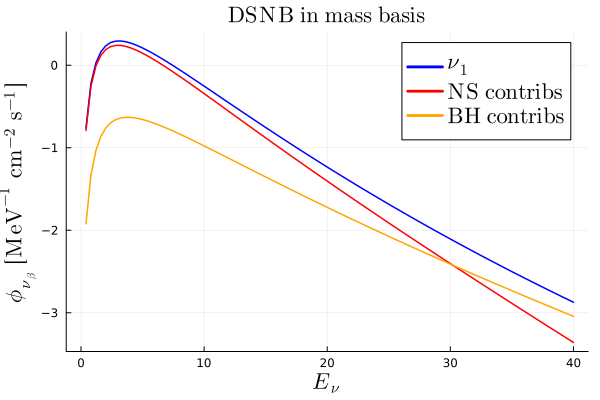

In [13]:
p1 = plot(es_dsnb, 
    [log10.(dsnb_1) log10.(dsnb_ccsn_1) log10.(dsnb_bhsn_1)],
    c=[:blue :red :orange],
    lw=1.5,
    ls=[:solid :solid :solid],
    label=[L"\nu_1" L"\mathrm{NS~contribs}" L"\mathrm{BH~contribs}"],
    title=L"\mathrm{DSNB~in~mass~basis}",
    ylabel=L"\phi_{\nu_\beta}~[\mathrm{MeV^{-1}~cm^{-2}~s^{-1}}]",
    xlabel=L"E_\nu",
    xguidefontsize=15,
    yguidefontsize=15,
    titlefontsize=15,
    legendfontsize=15,
)